<a href="https://colab.research.google.com/github/NeuronsUII/Pathologies_ArtDental_n/blob/main/Kotov%20Alexander/03_%D0%90%D1%83%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D1%81%D1%85%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импортируем библиотеки
import os # функции операционной системы
import shutil # модуль с набором функций высокого уровня для обработки файлов, групп файлов, и папок
import numpy as np # Работа с numpy-массивами
import requests # модуль для работы с HTTP-запросами
from urllib.parse import urlencode # импортируем функцию обработки URL
from PIL import Image # Отрисовка изображений
import matplotlib.pyplot as plt # Отрисовка графиков
from PIL import Image, ImageEnhance # Инструменты для работы с изображениями
import pandas as pd # для работы с табличными данными
import random # для работы с генератором случайных чисел
import math # модуль с набором функций для выполнения математических операций
%matplotlib inline

In [ ]:
# Загружаем архив с предварительно нарезанными изображениями суставов с Яндекс диска в папку content

# Получаем загрузочную ссылку
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/M3ZmUXxqGxOd_A'  # ссылка на файл (архив) на Яндекс диске
final_url = base_url + urlencode(dict(public_key=public_key))
# запрос ссылки на скачивание
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаем файл и сохраняем его в папку content
download_response = requests.get(download_url)
ARC_NAME = 'crop_img_joint' # имя архива с изображениями суставов
with open(ARC_NAME + '.zip', 'wb') as f:
    f.write(download_response.content) # сохраняем файл в папку content на google
# Распаковываем архив (zip-архив содержит папку crop_img_joint внутри которой png-файлы)
!unzip -o -q crop_img_joint.zip
# Удаляем файл архива, он нам больше не нужен для работы
os.remove(ARC_NAME + '.zip')

In [ ]:
# Список патологий
s_pathology = ['Норма','Дистальное положение','Дистракция','Компрессия','Латеральное смещение','Медиальное смещение','Мезиальное положение']
# Наименования срезов
s_slice = {'А': 'Аксиальный', 'К': 'Корональный', 'С': 'Сагиттальный'}
# Сторона
s_side = {'Л': 'Левый', 'П': 'Правый'}

# получим список всех вложенных файлов в директории /content/crop_img_joint
f_list = os.listdir(ARC_NAME)

# оставим в списке только png-файлы
for i in f_list:
    if i.endswith(".png") != True:
        f_list.remove(i)

# Обработаем список имен фалов в соответствии с их форматом

# Функция извлечения кода пациента из имени файла
def get_patient_code(filename, indentation):
    # вырежем из имени файла код пациента
    # вырезаем подстроку, начиная с символа строки под номером indentation
    # для имен файлов из начального датасета отступ (indentation) = 3 (например, 0АЛК104.png)
    # для имен файлов после аугментации отступ будет равным 15 (пример, 1СПЛ04Я09К10Р10К253.png)
    substring = filename[indentation:]
    # Обрезаем расширение файла
    patients_cut = substring.split(".")[0]
    return patients_cut

# сформируем список кодов пациентов и соберем общую статистику об исходном датасете
patients_code = [] # объявляем список с кодами пациентов
h_right, h_left, h_ax, h_cor, h_sag = 0, 0, 0, 0, 0 # переменные, содержащие количество снимком (правый/левый сустав, по трем проекциям)
h_pathology = np.zeros((len(s_pathology),), dtype=int) # количество снимков для каждой патологии
for i in f_list:
    # вырежем из имени файла код пациента
    patients_cut = get_patient_code(i, 3)
    # добавляем в список код пациента
    patients_code.append(patients_cut)
    # паталогии (от 0 до 6): отвечает 1-ый символ в имени файла
    h_pathology[int(i[0])] += 1
    # проекции: А, К или С
    if i[1] == 'А': # аксиальный срез
        h_ax += 1
    if i[1] == 'К': # корональный срез
        h_cor += 1
    if i[1] == 'С': # сагиттальный срез
        h_sag += 1
    # сторона: Л-левый сустав, П-правый сустав
    if i[2] == 'Л': # левый
        h_left += 1
    if i[2] == 'П': # правый
        h_right += 1
# исключим из списка кодов пациентов повторяющиеся
unique_list = list(set(patients_code))
patients_code = unique_list
# отсортируем список
patients_code.sort()

In [ ]:
# Выводим общую статистику по исходному датасету
print('\033[1mОБЩАЯ СТАТИСТИКА ПО ИСХОДНОМУ ДАТАСЕТУ:\033[0m\n ▪ Общее количество файлов:', len(f_list))
print(' ▪ Количество пациентов:', len(patients_code))
print(' ▪ Количество снимков левого сустава:', h_left)
print(' ▪ Количество снимков правого сустава:', h_right)
print(' ▪ Количество снимков по трем проекциям:')
print('   ▪ ', s_slice['А'].lower(),'срез: ', h_ax)
print('   ▪ ', s_slice['К'].lower(),'срез: ', h_cor)
print('   ▪ ', s_slice['С'].lower(),'срез: ', h_sag)
print(' ▪ Количество снимков по патологиям:')
for i in range(len(h_pathology)):
    print('   ▪ ',s_pathology[i].lower(),': ',h_pathology[i])

ОБЩАЯ СТАТИСТИКА ПО ИСХОДНОМУ ДАТАСЕТУ:
 ▪ Общее количество файлов: 50
 ▪ Количество пациентов: 22
 ▪ Количество снимков левого сустава: 20
 ▪ Количество снимков правого сустава: 30
 ▪ Количество снимков по трем проекциям:
   ▪  аксиальный срез:  15
   ▪  корональный срез:  15
   ▪  сагиттальный срез:  20
 ▪ Количество снимков по патологиям:
   ▪  норма :  12
   ▪  дистальное положение :  4
   ▪  дистракция :  3
   ▪  компрессия :  4
   ▪  латеральное смещение :  12
   ▪  медиальное смещение :  10
   ▪  мезиальное положение :  5


In [ ]:
# Формируем сводную таблицу (dataframe) по имеющимся данным по каждому пациенту
PCODE, PAT, HS, SL = 'Код пациента', 'Паталогии', 'Кол-во снимков', 'Срезы'
df = pd.DataFrame(columns=[PCODE, PAT, HS, SL])
row = 1 # начинаем писать в таблицу с 1-ой строки
# заполняем таблицу
for p in patients_code: # по каждому пациенту
    tmp_h_slice, tmp_pat, tmp_slice = 0, [], [] # инициализация временных переменных (кол-во снимков, виды патологий у пациента, снимки каких срезов есть)
    for i in f_list: # просматриваем список файлов
        tmp_s = get_patient_code(i, 3)
        if tmp_s == p: # отслеживаем: файл относится к текущему пациенту или нет
            tmp_h_slice += 1 # подсчет кол-ва снимков
            tmp_pat.append(s_pathology[int(i[0])]) # учет видов патологий у пациента
            tmp_slice.append(s_slice[i[1]]) # учет видов срезов на снимках
    # заполняем текущую строку
    df.at[row, PCODE] = p  # код пациента
    df.at[row, PAT]   = str(set(tmp_pat)).replace("{", "").replace("}", "") # имеющиеся паталогии
    df.at[row, HS]    = str(tmp_h_slice) # кол-во снимков
    df.at[row, SL]    = str(set(tmp_slice)).replace("{", "").replace("}", "") # виды снимков
    row += 1
display(df)

,Код пациента,Паталогии,Кол-во снимков,Срезы
1,К10,'Латеральное смещение',4,"'Аксиальный', 'Корональный'"
2,К104,'Норма',6,"'Аксиальный', 'Сагиттальный', 'Корональный'"
3,К107,'Мезиальное положение',2,'Сагиттальный'
4,К128,'Мезиальное положение',1,'Сагиттальный'
5,К13,'Норма',3,"'Аксиальный', 'Сагиттальный', 'Корональный'"
6,К137,'Медиальное смещение',4,"'Аксиальный', 'Корональный'"
7,К138,'Медиальное смещение',2,"'Аксиальный', 'Корональный'"
8,К151,'Медиальное смещение',4,"'Аксиальный', 'Корональный'"
9,К153,'Дистальное положение',1,'Сагиттальный'
10,К155,'Дистракция',1,'Сагиттальный'


In [ ]:
# Разделим файлы на обучающую (train_imgs) и тестовую (test_imgs) выборки
# Аугментированию будут подлежать только файлы для обучающей выборки
# В тестовую выборку войдут снимки пацентов К104, К137 и К175 (выбрал пациентнов по таблице с наибольшим кол-вом снимков и различными патологиями, с учетом долей ~80% (на обучающую и проверочную выборки) / ~20% (на тестовую))
test_pathients = ['К104', 'К137', 'К175']
train_imgs, test_imgs = [], []
for i in f_list: # просматриваем список файлов и сортируем их по принадлежности (входит пациент в список для тестовой выборки или нет)
    if get_patient_code(i, 3) in test_pathients:
        test_imgs.append(i) # добавляем файл в список для тестовой выборки
    else:
        train_imgs.append(i) # добавляем файл в список для обучающей выборки
# отобразим результат сортировки
print('Обучающая выборка:')
print(' ▪ количество пациентов:', len(patients_code) - len(test_pathients))
print(' ▪ количество файлов:', len(train_imgs), '(' + str(round(len(train_imgs)/len(f_list) * 100, 1)) + '%)')
print('\nТестовая выборка:')
print(' ▪ количество пациентов:', len(test_pathients))
print(' ▪ количество файлов:', len(test_imgs), '(' + str(round(len(test_imgs)/len(f_list) * 100, 1)) + '%)')

Обучающая выборка:
 ▪ количество пациентов: 19
 ▪ количество файлов: 36 (72.0%)

Тестовая выборка:
 ▪ количество пациентов: 3
 ▪ количество файлов: 14 (28.0%)


In [ ]:
# Аугментация обучающих данных.
# Увеличим объем обучающей выборки путем модификации изображений.
# Модификации будут подлежать изображения срезов для пациентов, которые не вошли в тестовую выборку
# В качестве инструментов "модификации" изображений будут применены: rotate, contrast, brightness, sharpness

# Создадим директории для обучающей и тестовой выборок
TRAIN_PATH = '/content/TRAIN_SRC' # директория с оригинальными исходными изображениями
TRAIN_AUG_PATH = '/content/TRAIN' # в этой директории будут в итоге храниться оригинальные изображения и модифицированные
TEST_PATH = '/content/TEST' # директория с оригинальными исходными изображениями для тестовой выборки (преобразованиям не подлежат)
if os.path.exists(TRAIN_PATH): # если папка уже существует, удалим ее со всем содержимым
    shutil.rmtree(TRAIN_PATH)
if os.path.exists(TRAIN_AUG_PATH): # если папка уже существует, удалим ее со всем содержимым
    shutil.rmtree(TRAIN_AUG_PATH)
if os.path.exists(TEST_PATH): # если папка уже существует, удалим ее со всем содержимым
    shutil.rmtree(TEST_PATH)
os.mkdir(TRAIN_PATH)
os.mkdir(TRAIN_AUG_PATH)
os.mkdir(TEST_PATH)

# Скопируем файлы из папки ARC_NAME в TRAIN_PATH и TEST_PATH по принадележности
for i in f_list:
    if i in train_imgs:
        shutil.copy('/content/' + ARC_NAME + '/' + i, TRAIN_PATH + '/' + i)
    if i in test_imgs:
        shutil.copy('/content/' + ARC_NAME + '/' + i, TEST_PATH + '/' + i)
# Удаляем папку ARC_NAME с изображениями. Она нам больше не нужна
# shutil.rmtree('/content/' + ARC_NAME)

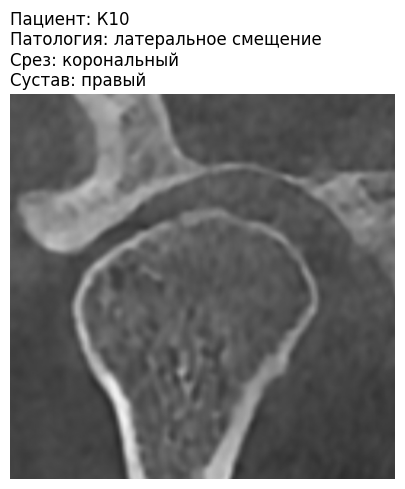

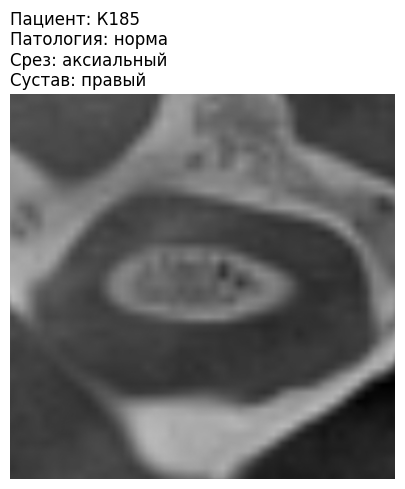

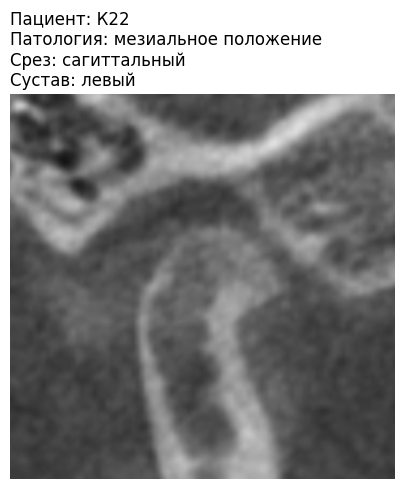

In [ ]:
# Выведем 3 любых снимка из обучающей выборки

# функция для вывода изображения (снимка)
def show_image(img, title):
    plt.figure(figsize=(8, 5)) # Cоздание полотна для рисования
    plt.imshow(img) # Отрисовка изображения
    plt.title(title, fontsize=12, loc='left') # Вывод заголовка
    plt.axis('off') # Отключение осей
    plt.show() # Вывод результата

for _ in range(3):
    # генерируем случайный индекс
    rnd_index =  random.randint(0, len(train_imgs) - 1)
    img  = Image.open(TRAIN_PATH + '/' + train_imgs[rnd_index]) # Открытие случайного изображения из датасета
    # вывод изображения с описанием
    show_image(img, 'Пациент: ' + get_patient_code(train_imgs[rnd_index], 3) +
               '\nПатология: ' + s_pathology[int(train_imgs[rnd_index][0])].lower() +
               '\nСрез: ' + s_slice[train_imgs[rnd_index][1]].lower() +
               '\nСустав: ' + s_side[train_imgs[rnd_index][2]].lower())

In [ ]:
# Сервисная функция для визуального сравнения исходного изображения с измененным
def show_image_pair(img1, img2):
    # Cоздание полотна для рисования двух изображений
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].imshow(img1) # Исходное изображение
    axs[0].axis('off')
    axs[1].imshow(img2) # Модифицированное изображение
    axs[1].axis('off')
    plt.show() # Вывод изображений

In [ ]:
# Функции: ПОВОРОТ ИЗОБРАЖЕНИЯ (rotate)

# Функция нахождения ширины и высоты прямоугольника наибольшей площади
# после поворота заданного прямоугольника на угол в градусах
def rotated_rect(w,    # Ширина изображения
                 h,    # Высота изображения
                 angle # Угол поворота в градусах
                 ):
    angle = math.radians(angle)
    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        x = 0.5 * side_short
        wr, hr = (x/sin_a, x/cos_a) if width_is_longer else (x/cos_a, x/sin_a)
    else:
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr, hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a
    return wr, hr

# Функция вращения (поворота) изображения на заданный угол
def img_rotate(img,   # Подаваемое изображение
               angle  # угол поворота
               ):
    # Вращение картинки с расширением рамки
    r = img.rotate(angle, expand=True)
    # Вычисление размеров прямоугольника обрезки максимальной площади
    # для размеров исходной картинки и угла поворота в градусах
    crop_w, crop_h = rotated_rect(img.width, img.height, angle)
    # Обрезка повернутого изображения и возврат результата
    w, h = r.size
    return r.crop(((w - crop_w) * 0.5, (h - crop_h) * 0.5,
                   (w + crop_w) * 0.5, (h + crop_h) * 0.5))

In [ ]:
# ПОВОРОТ/ВРАЩЕНИЕ (Rotate)
# angle < 0 - поворот вправо, angle > 0 поворот влево
angle = -15 # укажите угол поворота в градусах
rc = img_rotate(img, angle)
show_image_pair(img, rc)

In [ ]:
# ЯРКОСТЬ (Brightness)
# Коэффициент равный 1.0 возвращает копию исходного изображения.
# Меньшие коэффициенты означают меньшую яркость, а более высокие значения - большую яркость.
# Коэффициент равный 0.0, дает черное изображение.
enh = ImageEnhance.Brightness(img)
img_bright = enh.enhance(0.7) # укажите коэффициент яркости
show_image_pair(img, img_bright)

In [ ]:
# Контрастность (contrast)
# Коэффициент равный 1.0 возвращает копию исходного изображения.
# Меньшие коэффициенты означают меньшую контрастность, а более высокие значения - большую контрастность.
# Коэффициент равный 0, дает дает сплошное серое изображение
enh = ImageEnhance.Contrast(img) # Создание экземпляра класса Contrast
img_contr = enh.enhance(1.3)     # укажите коэффициента контраста
show_image_pair(img, img_contr)

In [ ]:
# Резкость/размытость (sharpness)
# Коэффициент равный 1.0 возвращает копию исходного изображения.
# Меньшие коэффициенты означают меньшую резкость (размытость), а более высокие значения - большую резкость.
# Коэффициент равный 0 дает размытое изображение.
# Коэффициент равный 2 дает четкое изображение.
enh = ImageEnhance.Sharpness(img)
img_sharp = enh.enhance(0.5) # укажите коэффициент резкости
show_image_pair(img, img_sharp)

In [ ]:
# Формируем финальный датасет для обучающей выборки

# 1. Копируем оригинальные изображения (применяется новый формат имен файлов, пример: 5АПЛ06Я10К09Р10К138.png)
for i in train_imgs:
    # Копируем файлы из папки TRAIN_PATH в TRAIN_AUG_PATH под переформатированными именами
    # для оригинальных изображений: П00 (поворот (по умолчанию П-направо) = 0 градусов), Я10 (яркость = 1.0), К10 (контрастность = 1.0), Р10 (резкость = 1.0)
    shutil.copy(TRAIN_PATH + '/' + i, TRAIN_AUG_PATH + '/' + i[:3] + 'П00Я10К10Р10' + get_patient_code(i, 3) + '.' + i.split(".")[-1])

In [ ]:
# 2. Преобразуем (модифицируем) изображения следующим образом:
#    Выполним поворот изображений от -10 град. до +10 град. с шагом 2 градуса.
#    На каждом шаге (для каждого угла поворота) изменим:
#      - яркость: от 0.7 до 1.3 с шагом 0.2;
#      - контрастность: от 0.5 до 1.3 с шагом 0.2;
#      - резкость/размытие: от 0.9 до 1.1 с шагом 0.2.
#    Результаты преобразований изображений записываем в папку TRAIN_AUG_PATH. Имя файла будет содержать информацию о проведенных преобразованиях.

# ПОВОРОТ (диапазон, шаг)
angle_from = -10
angle_to   =  10
angle_step =   2
# ЯРКОСТЬ
# Коэффициент равный 1.0 возвращает копию исходного изображения.
# Меньшие коэффициенты означают меньшую яркость, а более высокие значения - большую яркость.
# Коэффициент равный 0.0, дает черное изображение.
bright_from = 0.7
bright_to   = 1.3
bright_step = 0.2
# КОНТРАСТНОСТЬ
# Коэффициент равный 1.0 возвращает копию исходного изображения.
# Меньшие коэффициенты означают меньшую контрастность, а более высокие значения - большую контрастность.
# Коэффициент равный 0.0, дает дает сплошное серое изображение
contrast_from = 0.5
contrast_to   = 1.3
contrast_step = 0.2
# РЕЗКОСТЬ
# Коэффициент равный 1.0 возвращает копию исходного изображения.
# Меньшие коэффициенты означают меньшую резкость (размытость), а более высокие значения - большую резкость.
# Коэффициент равный 0 дает размытое изображение.
# Коэффициент равный 2 дает четкое изображение.
sharp_from = 0.9
sharp_to   = 1.1
sharp_step = 0.2

for i in train_imgs: # пробегаемся по списку файлов в папке TRAIN_PATH
    img  = Image.open(TRAIN_PATH + '/' + i) # Открытие i-го изображения
    for ra in np.arange(angle_from, angle_to, angle_step): # поворот изображения в заданном диапазоне углов
        r_img = img_rotate(img, ra)
        # определим значение префикса по направлению поворота (положительный угол - "Л"-лево, отрицательный - "П"-право)
        if ra < 0:
            prefix = 'П'
        else:
            prefix = 'Л'
        #show_image_pair(img, r_img)
        for br in np.arange(bright_from, bright_to, bright_step): # изменение яркости изображения в заданном диапазоне
            br_img = ImageEnhance.Brightness(r_img).enhance(br)
            # сохраняем изображение в файл
            br_img.save(TRAIN_AUG_PATH + '/'+ i[:3] + # первые три символа оставляем, как есть (патология, срез, сторона)
                        prefix + str(abs(ra)).zfill(2)[-2:] + # угол поворота (например, -16 градусов: П16; +2 градуса: Л02)
                        'Я' + str(round(br * 10)).zfill(2)[-2:] + # кодируем значение яркости (например, 0.5 кодируется, как К05)
                        'К10Р10' + # контрастность и резкость не менялись
                        get_patient_code(i, 3) + '.png') # код пациента
            # show_image_pair(img, br_img)
        for cntr in np.arange(contrast_from, contrast_to, contrast_step): # изменение контрастности изображения в заданном диапазоне
            c_img = ImageEnhance.Contrast(r_img).enhance(cntr)
            c_img.save(TRAIN_AUG_PATH + '/'+ i[:3] + # первые три символа оставляем, как есть (патология, срез, сторона)
                        prefix + str(abs(ra)).zfill(2)[-2:] + # угол поворота (например, -16 градусов: П16; +2 градуса: Л02)
                        'Я10' + # яркость не менялась
                        'К' + str(round(cntr * 10)).zfill(2)[-2:] + # кодируем значение контрастности (например, 1.3 кодируется, как К13)
                        'Р10' + # резкость не менялись
                        get_patient_code(i, 3) + '.png') # код пациента
            # show_image_pair(img, c_img)
        for shrp in np.arange(sharp_from, sharp_to, sharp_step): # изменение резкости/размытости изображения в заданном диапазоне
            sh_img = ImageEnhance.Sharpness(r_img).enhance(shrp)
            sh_img.save(TRAIN_AUG_PATH + '/'+ i[:3] + # первые три символа оставляем, как есть (патология, срез, сторона)
                        prefix + str(abs(ra)).zfill(2)[-2:] + # угол поворота (например, -16 градусов: П16; +2 градуса: Л02)
                        'Я10К10' + # яркость и контрастность не менялись
                        'Р' + str(round(cntr * 10)).zfill(2)[-2:] + # кодируем значение резкости/размытости (например, 1 кодируется, как К10)
                        get_patient_code(i, 3) + '.png') # код пациента
            # show_image_pair(img, sh_img)


In [ ]:
# СТАТИСТИКА:
# список полученных файлов в директории TRAIN_AUG_PATH
print('\033[1mОБУЧАЮЩАЯ ВЫБОРКА:\033[0m', TRAIN_AUG_PATH)
faug_list = os.listdir(TRAIN_AUG_PATH)
print('Полученное количество изображений: ', len(faug_list))
# Расклад по патологиям
h_pathology = np.zeros((len(s_pathology),), dtype=int) # список количества снимков для каждой патологии
for i in faug_list:
    h_pathology[int(i[0])] += 1 # паталогия (от 0 до 6): отвечает 1-ый символ в имени файла
print('Количество файлов по патологиям:')
for i in range(len(h_pathology)):
    print(' ▪ ',s_pathology[i].lower(),': ',h_pathology[i])
print('\n\033[1mТЕСТОВАЯ ВЫБОРКА:\033[0m', TEST_PATH)
test_list = os.listdir(TEST_PATH)
print('Количество изображений: ', len(test_list))
h_pathology = np.zeros((len(s_pathology),), dtype=int) # список количества снимков для каждой патологии
for i in test_list:
    h_pathology[int(i[0])] += 1 # паталогия (от 0 до 6): отвечает 1-ый символ в имени файла
print('Количество файлов по патологиям:')
for i in range(len(h_pathology)):
    print(' ▪ ',s_pathology[i].lower(),': ',h_pathology[i])

ОБУЧАЮЩАЯ ВЫБОРКА: /content/TRAIN
Полученное количество изображений:  3276
Количество файлов по патологиям:
 ▪  норма :  546
 ▪  дистальное положение :  364
 ▪  дистракция :  273
 ▪  компрессия :  364
 ▪  латеральное смещение :  728
 ▪  медиальное смещение :  546
 ▪  мезиальное положение :  455

ТЕСТОВАЯ ВЫБОРКА: /content/TEST
Количество изображений:  14
Количество файлов по патологиям:
 ▪  норма :  6
 ▪  дистальное положение :  0
 ▪  дистракция :  0
 ▪  компрессия :  0
 ▪  латеральное смещение :  4
 ▪  медиальное смещение :  4
 ▪  мезиальное положение :  0


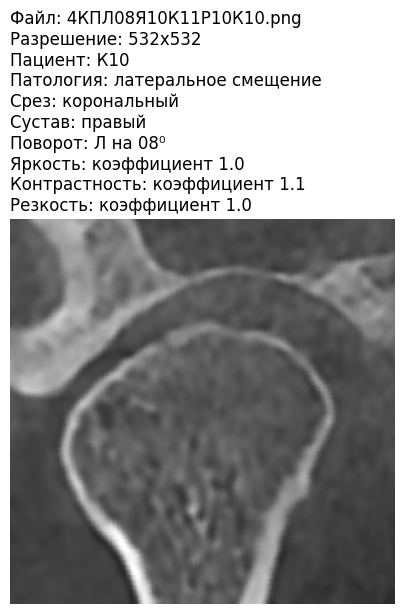

In [ ]:
# Вывод файла из /content/TRAIN на экран по порядковому номеру в списке (от 0 до КОЛ-ВО файлов)
n = 323 # номер
if n < 0:
    n = 0
if n >= len(faug_list):
    n = len(faug_list) - 1
img  = Image.open(TRAIN_AUG_PATH + '/' + faug_list[n]) # Открытие n-го изображения из датасета
show_image(img,'Файл: ' + faug_list[n] +
               '\nРазрешение: ' + str(img.size[0]) + 'x' + str(img.size[1]) +
               '\nПациент: ' + get_patient_code(faug_list[n], 15) +
               '\nПатология: ' + s_pathology[int(faug_list[n][0])].lower() +
               '\nСрез: ' + s_slice[faug_list[n][1]].lower() +
               '\nСустав: ' + s_side[faug_list[n][2]].lower() +
               '\nПоворот: ' + faug_list[n][3] + ' на ' + faug_list[n][4:6] + '⁰' +
               '\nЯркость: коэффициент ' + faug_list[n][7] + '.' + faug_list[n][8] +
               '\nКонтрастность: коэффициент ' + faug_list[n][10] + '.' + faug_list[n][11] +
               '\nРезкость: коэффициент ' + faug_list[n][13] + '.' + faug_list[n][14])

In [ ]:
# Создаем архив изображений с обучающей выборкой для выгрузки и дальнейшей работы
!zip -r -q '/content/train.zip' TRAIN
print('Размер train.zip:', str(round(os.path.getsize('/content/train.zip') / (1024 * 1024) , 2)), 'Мб')
# Архив с изображениями для тестовой выборки
!zip -r -q '/content/test.zip' TEST
print('Размер test.zip:', str(round(os.path.getsize('/content/test.zip') / (1024 * 1024) , 2)), 'Мб')

Размер train.zip: 452.47 Мб
Размер test.zip: 2.03 Мб
